<a href="https://colab.research.google.com/github/pbellot/ANFTDM2021/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse de sentiment sur les critiques d'IMDB

Le corpus d'origine peut être téléchargé ici : http://ai.stanford.edu/~amaas/data/sentiment/. Il contient plusieurs répertoires et autant de fichiers que de critiques de films.
Pour l'utiliser : placer le fichier (.tar.gz) téléchargé dans le répertoire du projet et le décompresser. Il faut ensuite le mettre en forme en utilisant le code fourni plus bas.

Le corpus déjà mis en forme en un seul fichier .csv est disponible ici : https://drive.google.com/file/d/1LnfB59FpNkmX3xVXAL3oc4YyeAIiXod5/view?usp=sharing

**Code source inspiré de** : https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

### Connexion du notebook à votre Google Drive pour accéder aux données

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ***!! Pensez à changer ci-dessous le nom du répertoire/dossier de départ dans votre Google Drive***

In [ ]:
repertoire_depart = '/content/drive/MyDrive/Colab Notebooks/'
nomCSV = repertoire_depart+'/movie_data.csv'

## Les import nécessaires

*NB : les modules doivent avoir auparavant été installés dans votre environnement Python. Cela peut se faire via la commande conda install si vous utilisez le gestionnaire conda/anaconda ou bien via pip. Dans le cadre de Google Colab, tous les modules sont déjà pré-installés, à l'exception de MulticoreTSNE.*


In [ ]:
#si en dehors de Google Colab alors faire auparavant depuis la console : pip install MulticoreTSNE
# et pour Google Colab : 
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68518 sha256=95d99d32caf7d66a89398bee9304fed60a4eb928329c1229f4cb7e6d605d30bf
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE


In [ ]:
# à faire systématiquement pour Google Colab
# à ne faire que lors de la 1ère utilisation du Notebook si exécution en local
import nltk
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import gensim

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

#pour l'installation de TensorFlow, voir ci-dessous
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Flatten, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

#faire auparavant depuis la console : conda install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import accuracy_score
from sklearn.metrics  import classification_report
from sklearn.metrics  import roc_curve
from sklearn.metrics  import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

Si utilisation du code en local (= hors de Google Colab) pour l'installation de Tensorflow, voir : https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

##### sur MacOS :
- voir https://www.tensorflow.org/install?hl=fr
- SI vous avez déjà un environnement prêt (XCode, Anaconda / Brew, Python 3.7.x, PyCharm) :
         utiliser conda peut être nécessaire selon le CPU : conda install tensorflow=2.0.0 (avec Python 3.7.1)
         (les versions de tensorflow installées par PyCharm 2020 peuvent ne pas fonctionner)
- SINON suivre : https://www.pyimagesearch.com/2019/12/09/how-to-install-tensorflow-2-0-on-macos/
- il est possible d'utiliser un GPU, y compris AMD :  https://github.com/plaidml/plaidml
- pour Mac OS 11 (Intel ou M1), voir : https://github.com/apple/tensorflow_macos

## Si utilisation à partir du corpus d'origine (mise en forme du corpus)
Le code ci-dessous n'est à exécuter que dans le cas où vous n'utilisez pas le corpus déjà mis en forme. Il vous permet de voir quelques manipulations de fichiers en Python pour aboutir ici à un seul fichier .csv réunissant l'ensemble des données.

La première étape consiste à intégrer l'ensemble des critiques annotées (polarité négative ou positive)
en un seul fichier au format CSV qui pourra être stocké en mémoire par un DataFrame (extension Pandas de Python).

### Création du fichier .csv global à partir du corpus d'origine

In [ ]:
#%%

# Conversion du corpus d'origine en un fichier .csv

import pandas as pd
import os

labels = {'pos':1, 'neg' : 0}
df = pd.DataFrame()
for f in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(repertoire_depart, f, l)
        for fichier in os.listdir(path):
            with open(os.path.join(path, fichier), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
df.columns=['review', 'polarity']

df.to_csv(nomCSV, index=False, encoding='utf-8')
df.head()

## Lecture du fichier .csv (corpus de données déjà mis en forme)

In [ ]:
df = pd.read_csv(nomCSV, encoding='utf-8')

## Exploration du corpus et premiers éléments statistiques

In [ ]:
print("Nombre total de critiques : ", len(df))
print("Nombre de critiques positives : ", len(df[df['polarity']==1]))
print("Nombre de critiques négatives : ", (df['polarity']==0).sum())
print("polarité : ", df['polarity'][1], " -- ", df['review'][1])
print("polarité : ", df['polarity'][2], " -- ", df['review'][2])

Nombre total de critiques :  50000
Nombre de critiques positives :  25000
Nombre de critiques négatives :  25000
polarité :  1  --  This is a gem. As a Film Four production - the anticipated quality was indeed delivered. Shot with great style that reminded me some Errol Morris films, well arranged and simply gripping. It's long yet horrifying to the point it's excruciating. We know something bad happened (one can guess by the lack of participation of a person in the interviews) but we are compelled to see it, a bit like a car accident in slow motion. The story spans most conceivable aspects and unlike some documentaries did not try and refrain from showing the grimmer sides of the stories, as also dealing with the guilt of the people Don left behind him, wondering why they didn't stop him in time. It took me a few hours to get out of the melancholy that gripped me after seeing this very-well made documentary.
polarité :  1  --  I really like this show. It has drama, romance, and comedy

### Analyse globale du lexique avec le module NLTK

In [ ]:
reviews = df.review.str.cat(sep=' ')
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
hapax = frequency_dist.hapaxes()

In [ ]:
print("Nombre total de mots ", len(tokens))
print("Nombre de mots différents : ", len(vocabulary))
print("Taille totale des critiques en nombre de caractères :", len(reviews))
print(len(hapax)," mots qui n'apparaissent qu'une fois.")
print("Parmi les mots qui n'apparaissent qu'une seule fois :")
for _ in range(30):
    print(hapax[_], " ", end='')
print('\nLe mot le plus fréquent, ', frequency_dist.max()," , apparait ", frequency_dist[frequency_dist.max()], " fois")

Nombre total de mots  13956777
Nombre de mots différents :  199788
Taille totale des critiques en nombre de caractères : 65521550
104683  mots qui n'apparaissent qu'une fois.
Parmi les mots qui n'apparaissent qu'une seule fois :
themeparks  Disney-MGM  artistically-inclined  conscience-less  monsieur  non-lonely  upsetting.  finger-sewing  boondoggling  Bathian  moneygrubbing  smarmy.  Olivier/Garson  cold-fish  highlife  Marchionesse  Udolpho  frazzled.  bunt  Lorelay  obsesion  adverterous  Giraurd  Schlater  MissCastaway.com  UNBELIEVABLE  Coober  Pedy  Docudrama  'Cobra  
Le mot le plus fréquent,  the  , apparait  573267  fois


## Visualisation de la distribution du lexique

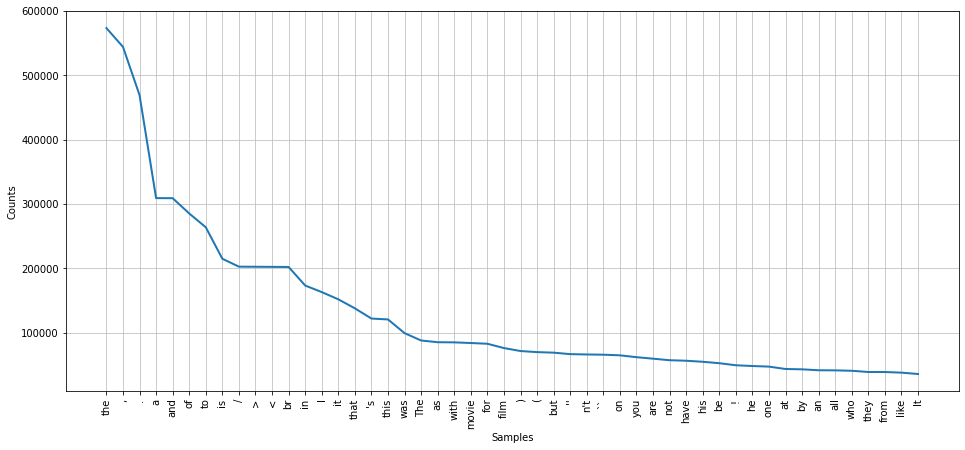

In [ ]:
plt.figure(figsize=(16,7))
frequency_dist.plot(50)

### Elimination des mots outils et des mots d'un seul caractère

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens = [w.lower() for w in tokens if not w.lower() in stop_words and len(w)>2]
vocabulary = set(tokens)
print("Taille du vocabulaire : ", len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
#sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

Taille du vocabulaire :  167375


## Visualisation du lexique après suppression des mots outils

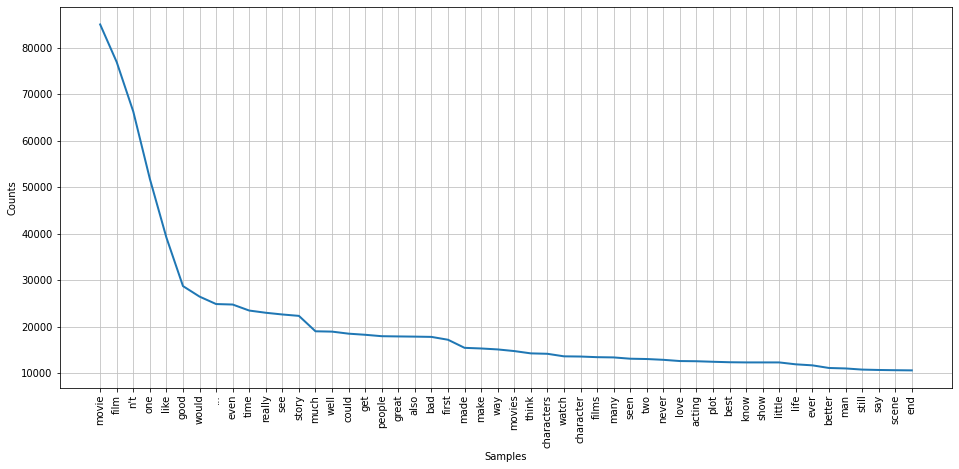

In [ ]:
plt.figure(figsize=(16,7))
frequency_dist.plot(50)

## Création de nuages de mots

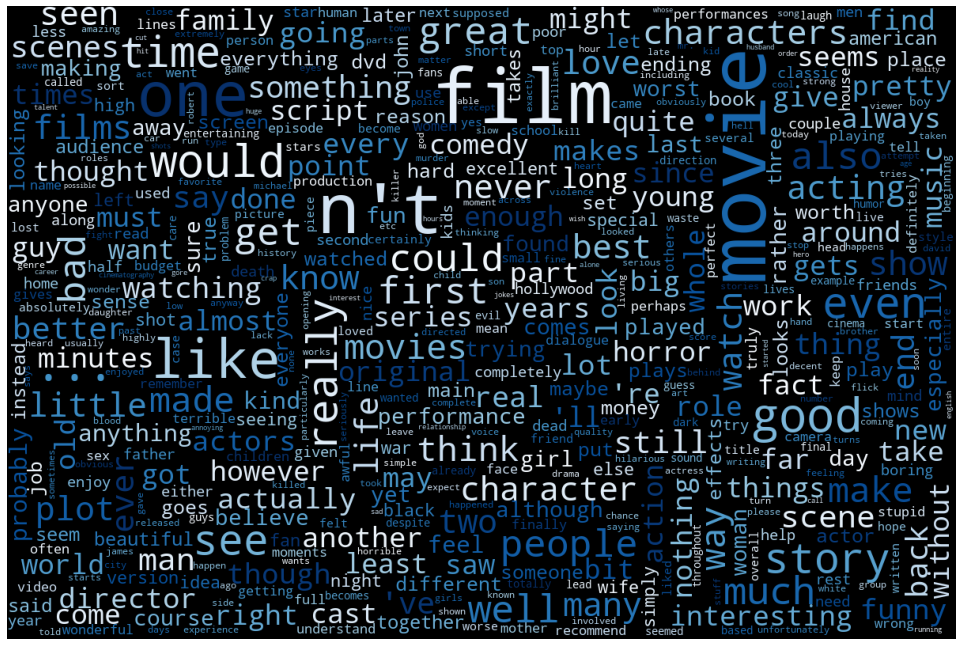

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=1200, height=800,
                    max_words=500,
                    max_font_size=100,
                    relative_scaling=0.5,
                    colormap='Blues',
                    normalize_plurals=True).generate_from_frequencies(frequency_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Différenciation entre les critiques positives et les négatives

#### Les critiques positives

In [ ]:
reviewsPositives = df.review[df.polarity==1].str.cat(sep=' ')
tokensPos = word_tokenize(reviewsPositives)
tokensPos = [w.lower() for w in tokensPos if not w.lower() in stop_words and len(w)>2]
vocabPos = set(tokensPos)
frequency_dist_Pos = nltk.FreqDist(tokensPos)
#sorted(frequency_dist_Pos,key=frequency_dist_Pos.__getitem__, reverse=True)[0:50]

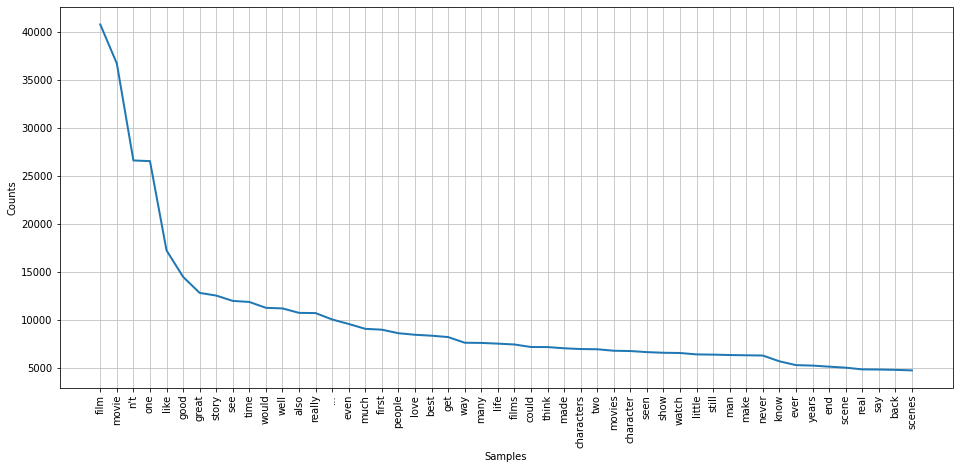

In [ ]:
plt.figure(figsize=(16,7))
frequency_dist_Pos.plot(50)

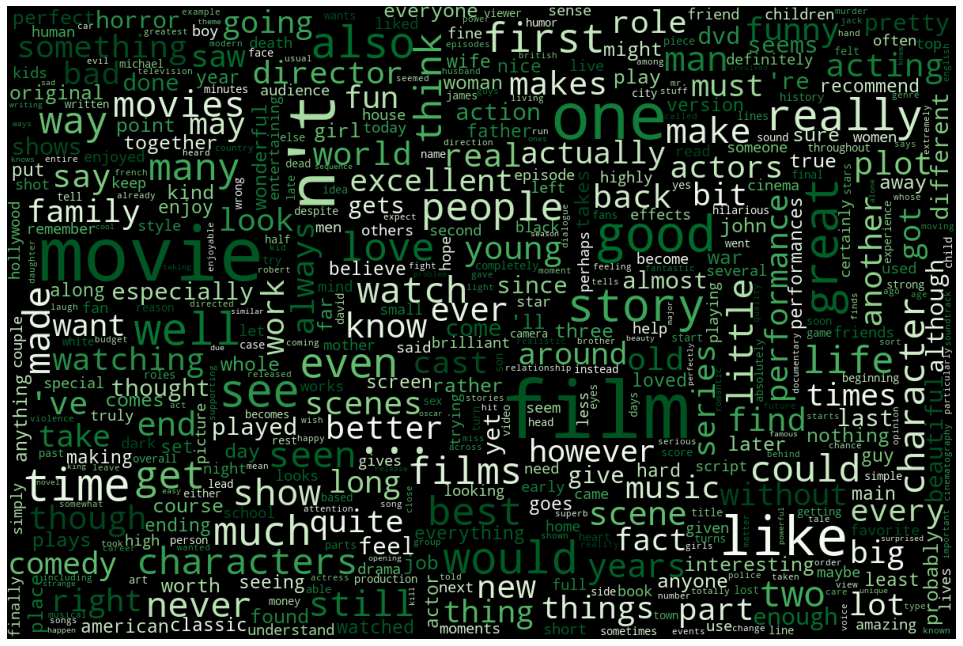

In [ ]:
wordcloud = WordCloud(width=1200, height=800,
                    max_words=500,
                    max_font_size=100,
                    relative_scaling=0.5,
                    colormap='Greens',
                    normalize_plurals=True).generate_from_frequencies(frequency_dist_Pos)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Les critiques négatives

In [ ]:
reviewsNegatives = df.review[df.polarity==0].str.cat(sep=' ')
tokensNeg = word_tokenize(reviewsNegatives)
tokensNeg = [w.lower() for w in tokensNeg if not w.lower() in stop_words and len(w)>2]
vocabNeg = set(tokensNeg)
frequency_dist_Neg = nltk.FreqDist(tokensNeg)
#sorted(frequency_dist_Neg,key=frequency_dist_Neg.__getitem__, reverse=True)[0:50]

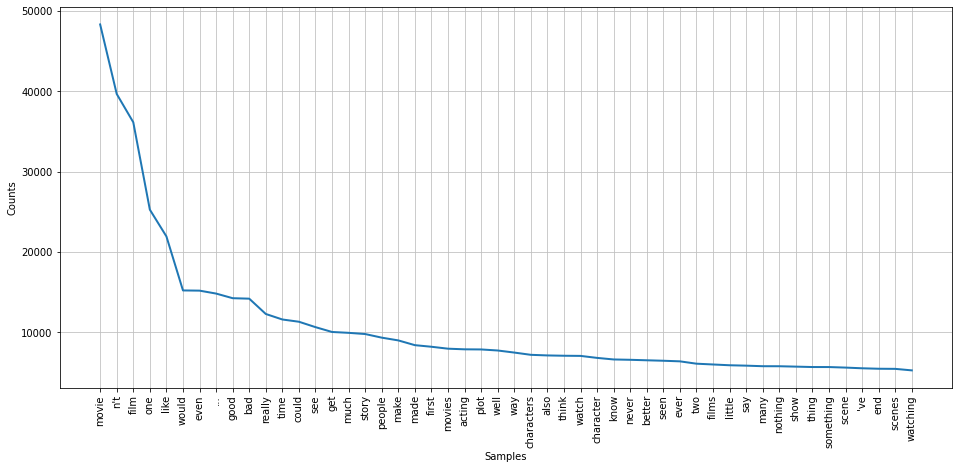

In [ ]:
plt.figure(figsize=(16,7))
frequency_dist_Neg.plot(50)

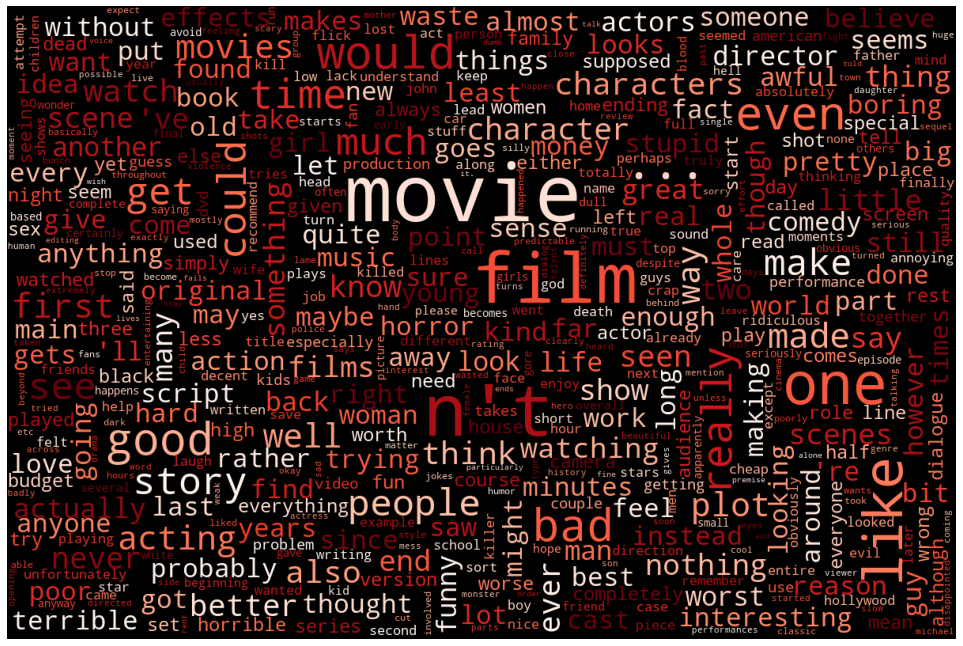

In [ ]:
wordcloud = WordCloud(width=1200, height=800,
                    max_words=500,
                    max_font_size=100,
                    relative_scaling=0.5,
                    colormap='Reds',
                    normalize_plurals=True).generate_from_frequencies(frequency_dist_Neg)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Une première méthode de classification en polarité positive ou négative
## Utilisation d'un classifieur bayésien

### Subdivision du corpus en 2 parties : l'une pour l'entraînement, l'autre pour le test

In [ ]:
X_train = df.loc[:24999, 'review'].to_numpy()
y_train = df.loc[:24999, 'polarity'].to_numpy()
X_test = df.loc[25000:, 'review'].to_numpy()
y_test = df.loc[25000:, 'polarity'].to_numpy()

Vectorisation et estimation des poids tf.idf de chaque mot (nombre d'occurrences x log de l'inverse du nombre de critiques contenant le mot).
les valeurs idf sont apprises sur le corpus d'entraînement, les mots outils sont conservés, les 10 000 mots les plus fréquents sont conservés seulement.

Voir https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer
pour les paramètres possibles.

In [ ]:
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [ ]:
clf = MultinomialNB().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)

In [ ]:
print(X_test[1], "\nprédit :", predicted[1], "polarité vraie ", y_test[1], "\n Vecteur TF.IDF : ", test_vectors[1])

Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The movie is nearly a cross-pollination of "Rosemary's Baby" and "The Exorcist"--but what a combination! Based on the best-seller by Jeffrey Konvitz, "The Sentinel" is entertainingly spooky, full of shocks brought off well by director Michael Winner, who mounts a thoughtfully downbeat en

No handles with labels found to put in legend.


Global Accuracy : 0.8454
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



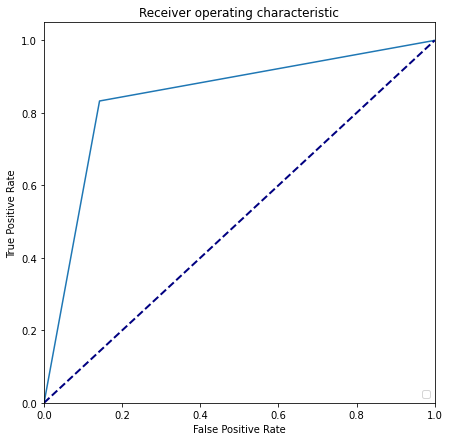

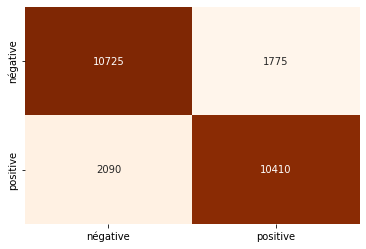

In [ ]:
print("Global Accuracy :", accuracy_score(y_test,predicted))
print(classification_report(y_test, predicted))

#Courbe ROC (voir https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)
fp, tp, _ = roc_curve(y_test, predicted)
plt.figure(figsize=(7,7))
plt.plot(fp, tp, 2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Matrice de confusion
conf_mat = confusion_matrix(y_test, predicted)

columns = ['négative', 'positive']
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
ax = seaborn.heatmap(df_cm, cmap='Oranges', annot=True, fmt="d", cbar=False)
                                                          

# Classification par réseau de neurones et plongements lexicaux (word embeddings)

### Pré-traitements (tokenisation, mise en minuscules, élimination des mots outils et des mots d'un seul caractère)


In [ ]:
review_lines = list()

for line in df['review']:
    tokens = word_tokenize(line)
    stop_words = set(stopwords.words('english'))
    tokens = [w.lower() for w in tokens if w.isalpha() and len(w)>1 and not w.lower() in stop_words]
    review_lines.append(tokens)

In [ ]:
nomEmbeddings = repertoire_depart+'/imdb_embeddings_word2vec_200_5_10'

### Apprentissage des plongements avec une approche Word2Vec
La méthode d'apprentissage est celle de GenSim.
voir : https://radimrehurek.com/gensim/models/word2vec.html



#### Apprentissage du modèle Word2Vec
Paramètres à régler : nombre de dimensions, taille de la fenêtre, nombre de coeurs du CPU à utiliser, nombre minimal d'occurrences)

In [ ]:
DIMENSION_EMBEDDINGS = 200
NB_OCCURRENCES_MIN = 10
TAILLE_FENETRE = 5

In [ ]:
model = gensim.models.Word2Vec(sentences=review_lines, size=DIMENSION_EMBEDDINGS, window=TAILLE_FENETRE, workers=-1, min_count=NB_OCCURRENCES_MIN)
motsComplet = list(model.wv.vocab)

In [ ]:
print ("nombre de mots retenus : ", len(motsComplet))

nombre de mots retenus :  26964


In [ ]:
print(model.wv['movie'])

#### Enregistrement du modèle appris
(ici format réduit : gain de place mais ne permet pas de continuer l'entraînement avec de nouveaux textes ajoutés -- pour enregistrer un modèle complet qui permet l'ajout, utiliser model.save à la place)

In [ ]:
model.wv.save_word2vec_format(nomEmbeddings, binary=False)

### Exploration de l'espace de représentation

#### Recherche de mots similaires à un mot donné

In [ ]:
print("Taille du vocabulaire : ", len(motsComplet))
print("Les mots les plus proches de horrible sont :")
print(model.wv.most_similar('horrible'))
print("Les mots les plus proches de superb sont :")
print(model.wv.most_similar('superb'))

Taille du vocabulaire :  26964
Les mots les plus proches de horrible sont :
[('shrek', 0.27949029207229614), ('mencia', 0.2793031930923462), ('giamatti', 0.25816991925239563), ('nessie', 0.2510564923286438), ('mj', 0.24664290249347687), ('pastime', 0.24646086990833282), ('biscuit', 0.24379463493824005), ('playboy', 0.23791441321372986), ('aimée', 0.23760011792182922), ('obelix', 0.23725222051143646)]
Les mots les plus proches de superb sont :
[('unsure', 0.27323463559150696), ('sprays', 0.2695443034172058), ('recipes', 0.2589505910873413), ('ensconced', 0.24900010228157043), ('smell', 0.239506334066391), ('worthless', 0.23556403815746307), ('alfred', 0.23485802114009857), ('resultant', 0.2346126139163971), ('nbc', 0.23362207412719727), ('fend', 0.23314392566680908)]


#### Exploration graphique globale

##### A l'aide d'une ACP
La méthode utilisée permet de visualiser l'ensemble des mots du vocabulaire retenu ou bien des mots spécifiques.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


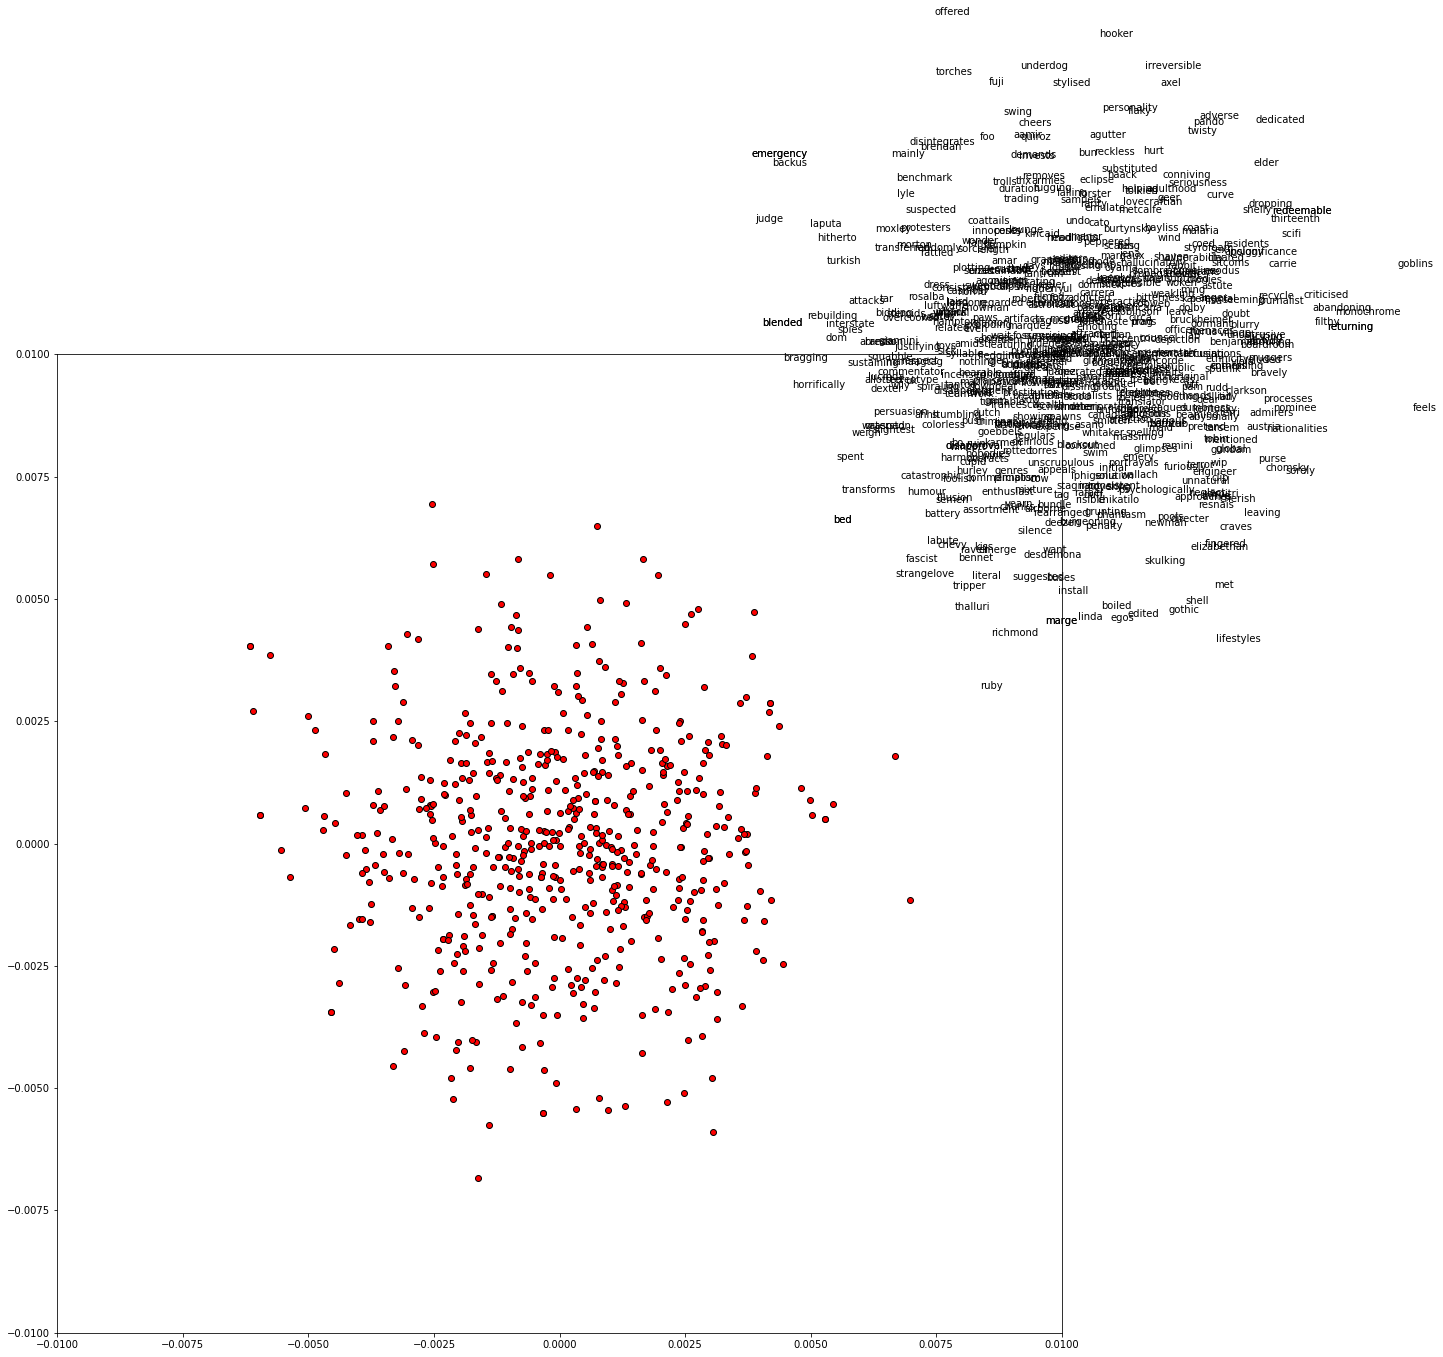

In [ ]:
# d'après https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(motsComplet, sample)
        else:
            words = [ word for word in motsComplet ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(18,18))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    plt.xlim(-0.01,0.01)
    plt.ylim(-0.01,0.01)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.01, y+0.01, word)


#display_pca_scatterplot(model, ['superb', 'good', 'terrible', 'awful', 'pathetic', 'outstanding', 'terrific', 'bad'])
display_pca_scatterplot(model, sample=600)

##### A l'aide de l'approche t-NSE
voir https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
pour multi-coeurs : https://github.com/DmitryUlyanov/Multicore-TSNE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


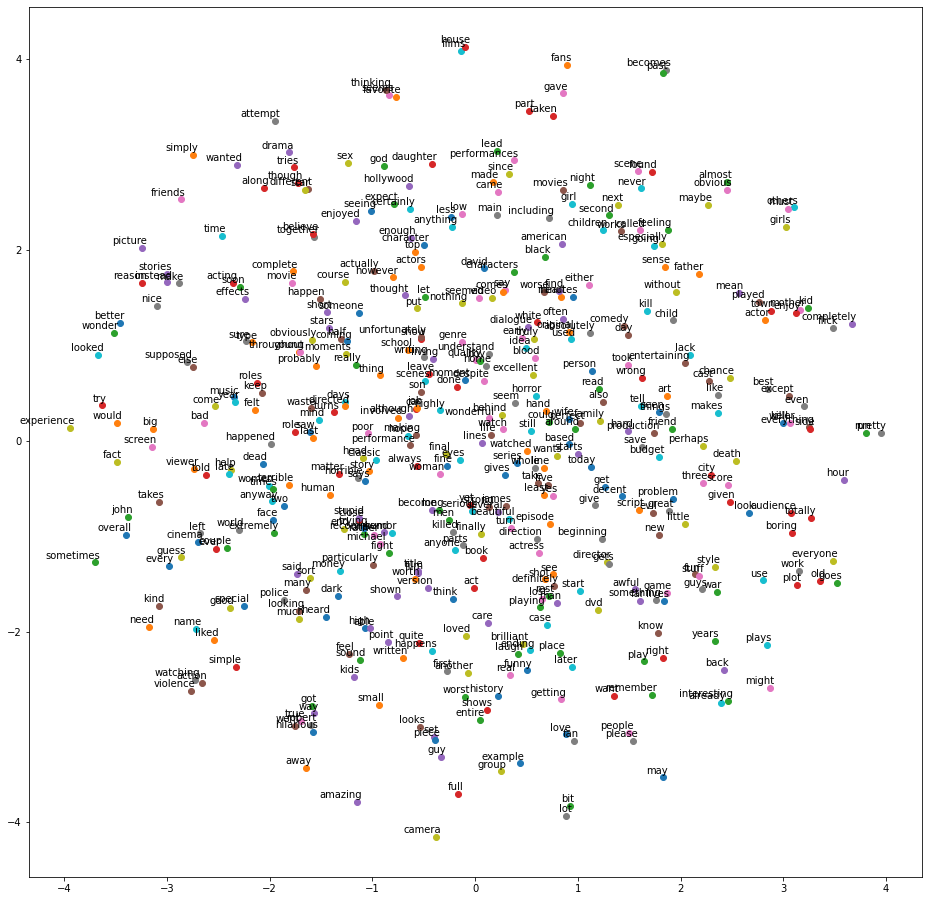

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if frequency_dist[word]>2000:
            tokens.append(model[word])
            labels.append(word)

    #version Sci-kit de Tsne
    #tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23, verbose=True)
    #new_values = tsne_model.fit_transform(tokens)

    #version Multicore de Tsne
    tsne_model = TSNE(perplexity=40, n_components=2, init='random', n_iter=2500, random_state=23, verbose=True, n_jobs=12)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model)

### Apprentissage du modèle neuronal de classification en exploitant une projection des critiques sur l'espace de représentation

Les critiques des films doivent être vectorisées dans l'espace de représentation. Il s'agit donc de représenter ces phrases dans une matrice de vecteurs de mots.
Par ailleurs, les critiques doivent être tronquées pour être de longueur égale. Il faut ainsi définir un nombre de mots maximum : au-delà, les mots suivants seront ignorés.

#### Tokenization avec les fonctions de TensorFlow / Keras
voir : https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

In [ ]:
tokenizer_obj = Tokenizer(oov_token='UNK', char_level=False)
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

In [ ]:
print (len(tokenizer_obj.word_index), " mots différents ont été trouvés")

96728  mots différents ont été trouvés


In [ ]:
maxlen = 128

In [ ]:
review_pad = pad_sequences(sequences, maxlen)
polarites = df['polarity'].to_numpy()

#### Construction de la matrice des plongements des mots des critiques

##### Ouverture et lecture du modèle de plongements Word2Vec

In [ ]:
embeddings_index = {}
print("Utilisation du modèle Word2Vec : ", nomEmbeddings)
with open(nomEmbeddings, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs
print("Nombre de mots dans le modèle : ", len(embeddings_index))
print("Dimensions de l'espace : ", len(coefs))

Utilisation du modèle Word2Vec :  /content/drive/MyDrive/Colab Notebooks//imdb_embeddings_word2vec_200_5_10
Nombre de mots dans le modèle :  26965
Dimensions de l'espace :  200


##### Projection dans l'espace de représentation

In [ ]:
nombremots = len(tokenizer_obj.word_index) + 1
#mise à zéro d'une matrice de nombremots lignes et de la taille des embeddings comme nombre de colonnes
embedding_matrix = np.zeros((nombremots, DIMENSION_EMBEDDINGS))

for word, i in tokenizer_obj.word_index.items():
    if i > nombremots:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print(nombremots)

96729


### Définition de l'architecture du réseau neuronal

In [ ]:
model = Sequential()
embedding_layer = Embedding(nombremots, DIMENSION_EMBEDDINGS,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)
model.add(embedding_layer)

model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))

#forward_layer = LSTM(10, return_sequences=True)
#backward_layer = LSTM(10, activation='relu', return_sequences=True,
#                       go_backwards=True)
#model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
#                         input_shape=(5, 10)))

# si pas GRU / LSTM mais couches denses directement alors la matrice des plongements doit être "mise à plat" :
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#pour un descriptif des loss functions : https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 200)          19345800  
_________________________________________________________________
gru (GRU)                    (None, 32)                22464     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 19,368,537
Trainable params: 22,737
Non-trainable params: 19,345,800
_________________________________________________________________


#### Entraînement du modèle à partir des plongements

Séparation en deux corpus, l'un d'entraînement et l'autre de validation par sélection aléatoire.

In [ ]:
VALIDATION_SPLIT = 0.3
# mélange aléatoire de l'ensemble des critiques :
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = polarites[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

# séparation entre données d'entraînement et données de test :
X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

print("Dimension X_train_pad ", X_train_pad.shape)
print("Dimension y_train ", y_train.shape)
print("Dimension X_test_pad ", X_test_pad.shape)
print("Dimension y_test ", y_test.shape)

Dimension X_train_pad  (35000, 128)
Dimension y_train  (35000,)
Dimension X_test_pad  (15000, 128)
Dimension y_test  (15000,)


Appel de la méthode entraînant le réseau et test au fur et à mesure des époques :

In [ ]:
#selon la configuration de votre machine, des conflits entre bibliothèques peuvent survenir. 
#Si Python quitte brutalement la ligne suivante peut permettre de contourner le problème
#sinon la mettre en commentaires
os.environ['KMP_DUPLICATE_LIB_OK']='True'

history = model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/5
1094/1094 [==============================] - 176s 157ms/step - loss: 0.5419 - accuracy: 0.7058 - val_loss: 0.3234 - val_accuracy: 0.8605
Epoch 2/5
1094/1094 [==============================] - 174s 159ms/step - loss: 0.3301 - accuracy: 0.8585 - val_loss: 0.3047 - val_accuracy: 0.8703
Epoch 3/5
1094/1094 [==============================] - 175s 160ms/step - loss: 0.3040 - accuracy: 0.8719 - val_loss: 0.3077 - val_accuracy: 0.8683
Epoch 4/5
1094/1094 [==============================] - 174s 159ms/step - loss: 0.2950 - accuracy: 0.8754 - val_loss: 0.2880 - val_accuracy: 0.8792
Epoch 5/5
1094/1094 [==============================] - 174s 159ms/step - loss: 0.2726 - accuracy: 0.8829 - val_loss: 0.2876 - val_accuracy: 0.8787


### Enregistrement du modèle

In [ ]:
nomModele = repertoire_depart+'/../modeleACC80'

In [ ]:
model.save(nomModele)

In [ ]:
del model

### Lecture du modèle appris

In [ ]:
#la ligne suivante peut provoquer une erreur provenant d'une incompatibilité entre tensorflow et le module h5py
#en version 3.x --> dans ce cas, installer la version 2.10.0 : conda install h5py==2.10.0
model = keras.models.load_model(nomModele)

## Analyse des résultats

In [ ]:
_, train_acc = model.evaluate(X_train_pad, y_train, verbose=1)
_, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

469/469 [==============================] - 10s 21ms/step - loss: 0.2899 - accuracy: 0.8821
Train: 0.927, Test: 0.882


### Visualisation de l'historique de l'apprentissage

voir : Display Deep Learning Model Training History in Keras
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

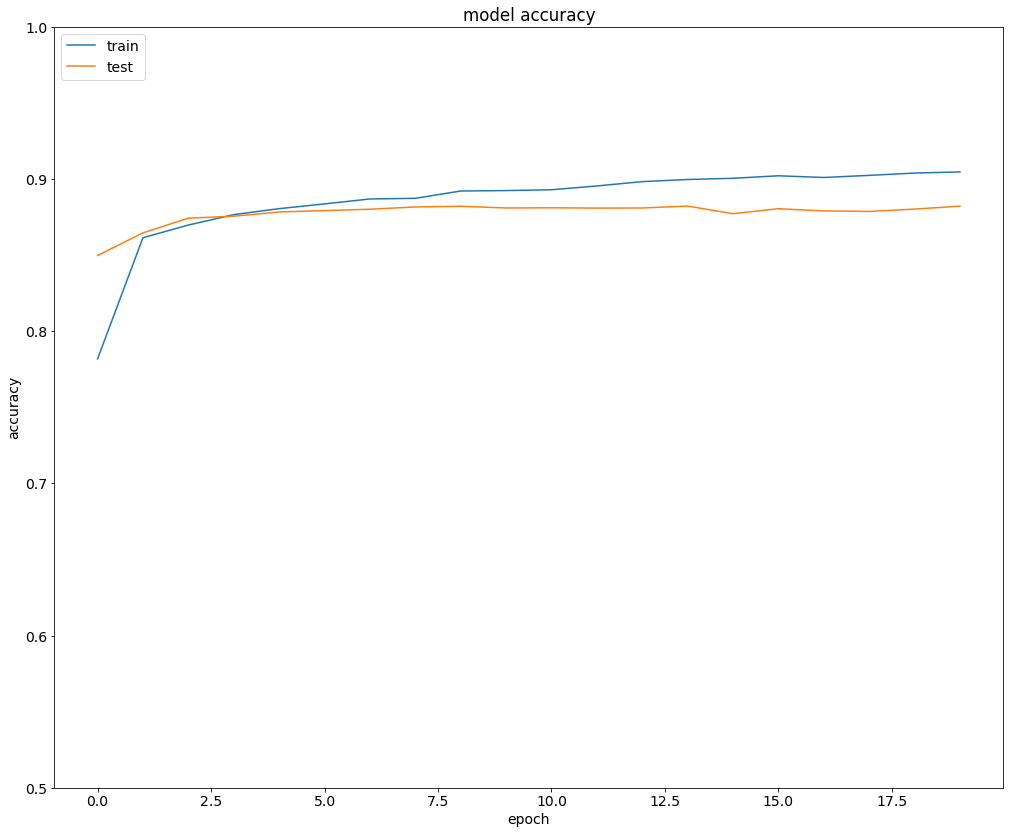

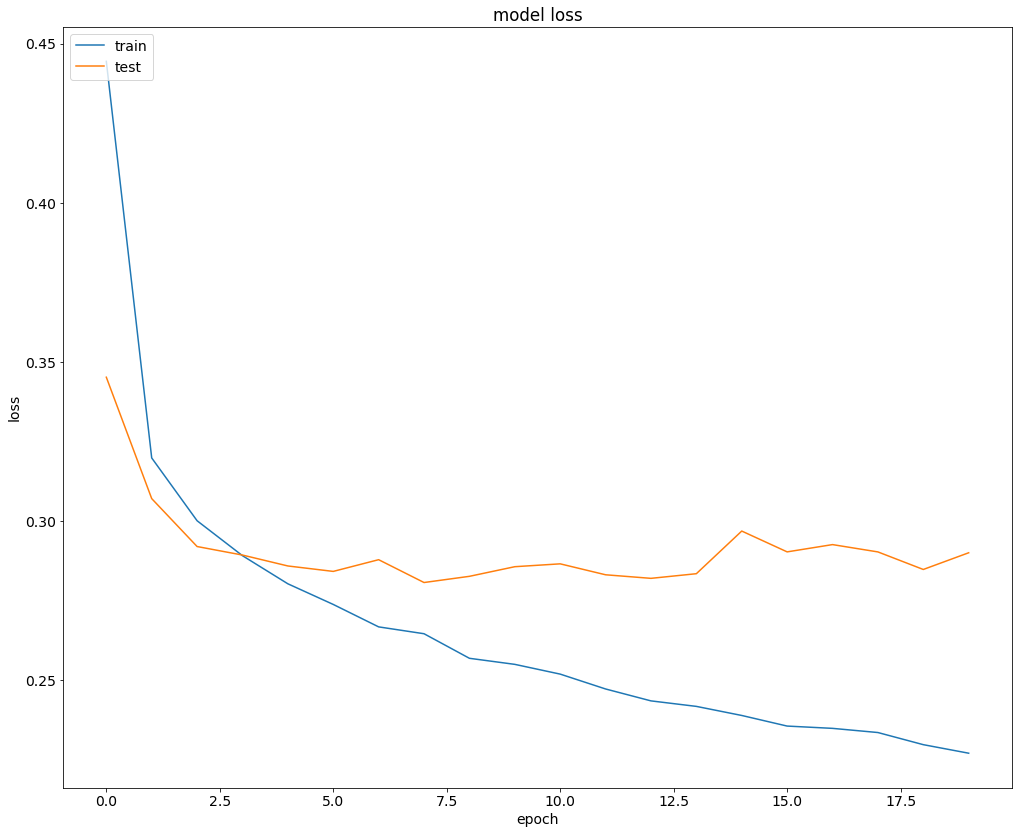

In [ ]:
plt.figure(figsize=(17,14))
plt.rc('font', size=14)
plt.ylim(0.5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(17,14))
plt.rc('font', size=14)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()